In [146]:
import numpy as np

class BasicNNModule:
    def __init__(self):
        self.lr = 0.001

class SingleLinear(BasicNNModule):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.weights = np.ones((out_features, in_features)) * 0.5
        self.bias = np.zeros(out_features)

    def forward(self, x):
        return np.matmul(x, self.weights.T) + self.bias
    
    def backward(self, delta_next_layer, w_next_layer, b_next_layer, a_cur_layer, y_last_layer):
        # print(d2y.shape, y2i.shape, y_last_layer.shape)
        # delta = d2y * y2i
        delta = (np.matmul(delta_next_layer.T, w_next_layer) * a_cur_layer).T
        # print(delta)
        # L2 regularization
        self.weights += self.lr * (np.matmul(delta, y_last_layer) - 0.01 * self.weights)
        # self.weights += self.lr * np.matmul(delta, y_last_layer)
        self.bias += self.lr * delta.T[0]
        return delta, self.weights, self.bias
    
    def softmax_backward(self, y, label, y_last_layer):
        delta = (y - label).T
        # print('before update:', self.weights, self.bias)
        # print(delta.shape, y_last_layer.shape, self.bias.shape)

        # L2 regularization
        self.weights += self.lr * (np.matmul(delta, y_last_layer) - 0.01 * self.weights)
        # self.weights += self.lr * np.matmul(delta, y_last_layer)

        self.bias += self.lr * delta.T[0]
        # print('after update:', self.weights, self.bias)
        return delta, self.weights, self.bias

class relu:
    def forward(self, x):
        return np.maximum(x, 0)
    
    def backward(self, x):
        return np.where(x > 0, 1, 0)
    
class Softmax:
    def forward(self, x):
        # 減去最大值以防止 overflow
        x = x - np.max(x, axis=1, keepdims=True)
        exp_x = np.exp(x)
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)
    


In [ ]:
import numpy as np

with open('Iris.csv') as f:
    data = f.readlines()[1:]

data = [line.strip().split(',')[1:] for line in data]
data = np.array(data)
labels = []

classes = np.unique(data[:, 4])

for d in data:
    for cls in classes:
        if d[4] == cls:
            one_hot = np.zeros(len(classes))
            one_hot[classes.tolist().index(cls)] = 1
            labels.append(one_hot)

inputs = data[:, :4].astype(np.float32)

inputs = (inputs - np.mean(inputs, axis=0)) / np.std(inputs, axis=0)

labels = np.array(labels)

# 打亂數據
idx = np.random.permutation(len(inputs))
inputs = inputs[idx]
labels = labels[idx]


linear_1 = SingleLinear(4, 5)
relu_1 = relu()
linear_2 = SingleLinear(5, 5)
relu_2 = relu()
linear_3 = SingleLinear(5, 3)
softmax_3 = Softmax()

for _ in range(5):

    for input, label in zip(inputs, labels):
        input = input.reshape(1, -1)
        # print(input, label)
        i_1 = linear_1.forward(input)
        y_1 = relu_1.forward(i_1)
        i_2 = linear_2.forward(y_1)
        y_2 = relu_2.forward(i_2)
        i_3 = linear_3.forward(y_2)
        print("i_3", i_3)
        y_3 = softmax_3.forward(i_3)
        print("y_3", y_3)
        print("label", label)
        delta_3, w_3, b_3 = linear_3.softmax_backward(y_3, label, y_2)
        delta_2, w_2, b_2 = linear_2.backward(delta_3, w_3, b_3, relu_2.backward(i_2), y_1)
        delta_1, w_1, b_1 = linear_1.backward(delta_2, w_2, b_2, relu_1.backward(i_1), input)
        # print('delta_3:\n', delta_3)
        # print('w_3:\n', w_3)
        # print('b_3:\n', b_3)
        
        # print('delta_2:\n', delta_2)
        # print('w_2:\n', w_2)
        # print('b_2:\n', b_2)
        # break
        # delta_1 = linear_1.backward(- ())
    

In [135]:
np.matmul(delta_3.T, w_3)

array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]])

In [171]:
class Softmax:
    def forward(self, x):
        # 減去最大值以防止 overflow
        x = x - np.max(x, axis=1, keepdims=True)
        exp_x = np.exp(x)
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)
Softmax().forward(np.array([[1, 5, 2]]))

array([[0.01714783, 0.93623955, 0.04661262]])

# =======================================

In [ ]:
def init_params():
    W1 = np.ones((4, 10))
    b1 = np.zeros((1, 10))
    W2 = np.ones((10, 3))
    b2 = np.zeros((1, 3))
    return W1, b1, W2, b2

def relu(x):
    return np.maximum(x, 0)

def d_relu(x):
    return x > 0

def softmax(x):
    exp_x = np.exp(x)
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

def forward_prop(W1, b1, W2, b2, X):

    # X shape: (bs, n_features)
    I1 = np.matmul(X, W1) + b1  
    Y1 = relu(I1)

    I2 = np.matmul(Y1, W2) + b2
    Y2 = softmax(I2)
    return I1, Y1, I2, Y2

def backward_prop(I1, Y1, Y2, W2, X, Y):

    # 設定標準化因子 (batch size的倒數) 將梯度標準化，避免 batch size 過大造成梯度累積過大
    m = X.shape[0]
    norm_factor = 1 / m
    
    delta_2 = Y2 - Y  # (bs, 3)

    # Y1.T shape -> (n_layer1, bs)
    # delta_2 shape -> (bs, n_layer2)

    dW2 = norm_factor * np.matmul(Y1.T, delta_2)  
    db2 = norm_factor * np.sum(delta_2, axis=0, keepdims=True)

    # dW2 shape -> (n_layer1, n_layer2)
    # db2 shape -> (1, n_layer2)

    # ========================================

    # delta_2 shape -> (bs, n_layer2)
    # W2.T shape -> (n_layer2, n_layer1)
    # d_relu(I1) shape -> (bs, n_layer1)

    delta_1 = np.matmul(delta_2, W2.T) * d_relu(I1)  
 
    # X.T shape -> (n_features, bs)
    # delta_1 shape -> (bs, n_layer1)
    
    dW1 = norm_factor * np.matmul(X.T, delta_1)  
    db1 = norm_factor * np.sum(delta_1, axis=0, keepdims=True)

    # dW1 shape -> (n_features, n_layer1)
    # db1 shape -> (1, n_layer1)
    
    return dW1, db1, dW2, db2

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, lr):
    W1 = W1 - lr * dW1
    b1 = b1 - lr * db1
    W2 = W2 - lr * dW2
    b2 = b2 - lr * db2
    return W1, b1, W2, b2

def get_predictions(A2):
    return np.argmax(A2, axis=1)

def get_accuracy(predictions, Y):
    Y = np.argmax(Y, axis=1)
    return np.sum(predictions == Y) / Y.size

def gradient_descent(X_train, Y_train, X_val, Y_val, alpha, iterations, bs):
    # X_train -> (n_samples, n_features)
    # Y_train -> (n_samples, n_classes) one-hot 
    
    W1, b1, W2, b2 = init_params()
    
    # 將全部的資料打包成 batch，每個 batch 的大小為 bs
    X_batch = X_train.reshape(-1, bs, X_train.shape[1])
    Y_batch = Y_train.reshape(-1, bs, Y_train.shape[1])
    
    for i in range(iterations):
        loss = 0
        for X, Y in zip(X_batch, Y_batch):
          
            # print('Y shape:', Y.shape, 'Y_all shape:', Y_all.shape)
            I1, Y1, I2, Y2 = forward_prop(W1, b1, W2, b2, X)
            dW1, db1, dW2, db2 = backward_prop(I1, Y1, Y2, W2, X, Y)
            W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
            loss += -np.sum(Y * np.log(Y2))

        if i % 1 == 0:
            print("Iteration: ", i)
            print("Loss: ", loss)
            _, _, _, pred = forward_prop(W1, b1, W2, b2, X_val)
            predictions = get_predictions(pred)
            print('Acc:', get_accuracy(predictions, Y_val))
            # print(predictions, Y)
        break

    return W1, b1, W2, b2

In [ ]:
import numpy as np

# 固定隨機種子，確保同參數下每次結果都相同
np.random.seed(1)

with open('Iris.csv') as f:
    data = f.readlines()[1:]

data = [line.strip().split(',')[1:] for line in data]
data = np.array(data)
labels = []

classes = np.unique(data[:, 4])

for d in data:
    for cls in classes:
        if d[4] == cls:
            one_hot = np.zeros(len(classes))
            one_hot[classes.tolist().index(cls)] = 1
            labels.append(one_hot)

inputs = data[:, :4].astype(np.float32)

# inputs = (inputs - np.mean(inputs, axis=0)) / np.std(inputs, axis=0)

labels = np.array(labels)

# 打亂數據
idx = np.random.permutation(len(inputs))

X_data = inputs[idx]
# Y_train = np.argmax(labels, axis=0)

Y_data = labels[idx]

train_size = int(len(X_data) * 0.8)
val_size = len(X_data) - train_size

X_train, Y_train = X_data[:train_size], Y_data[:train_size]
X_val, Y_val = X_data[val_size:], Y_data[val_size:]

print(X_train.shape)

batch_size = 120
lr = 0.05

W1, b1, W2, b2 = gradient_descent(X_train, Y_train, X_val, Y_val, lr, 30, batch_size)
# W1, b1, W2, b2

(120, 4)
d_relu(I1): (120, 10)
Iteration:  0
Loss:  131.83347464017316
Acc: 0.36666666666666664


## =================== 改良 =====================


### Xavier initialization
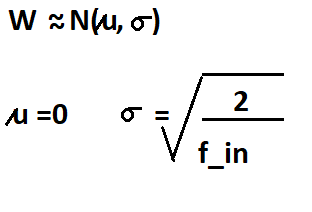

In [114]:
import numpy as np
import matplotlib.pyplot as plt

class ReLU:
    def forward(x):
        return np.maximum(x, 0)
    def backward(x):
        return x > 0
    
class LeckyReLU:
    def __init__(self, alpha=0.01):
        self.alpha = alpha
    def forward(self, x):
        return np.where(x > 0, x, self.alpha * x)
    def backward(self, x):
        return np.where(x > 0, 1, self.alpha)

class Softmax:
    def forward(x):
        exp_x = np.exp(x)
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

class CrossEntropyLoss:
    def cal_loss(y, label):
        return -np.sum(label * np.log(y))

class MLP:
    def __init__(self, params_set_list: list):
    
        self.params_set_list = params_set_list
        self.params = self.weight_init(params_set_list)

        # momentum 初始化動量為 0
        self.velocity = {
            'w': [np.zeros_like(w) for w in self.params['w']],
            'b': [np.zeros_like(b) for b in self.params['b']]
        }

    def weight_init(self, params_set_list: list) -> dict:
        params = {'w' : [], 'b': [], 'act_func': []}
        for in_features, out_features, act_func in params_set_list:
            # 使用 xavier initalization 初始化 weight
            # source: https://www.numpyninja.com/post/weight-initialization-techniques

            # w 是高斯分佈的隨機數，所以使用 xavier init 時分子為 2
            w = np.random.randn(in_features, out_features) * np.sqrt(2 / in_features)
            b = np.zeros((1, out_features))
            params['w'].append(w)
            params['b'].append(b)
            params['act_func'].append(act_func)
        return params
    
    def update_params(self, params: dict, params_delta: dict, lr, alpha) -> dict:


        for idx, (w, b, dW, db) in enumerate(zip(params['w'], params['b'], params_delta['W'][::-1], params_delta['b'][::-1])):
            # 從 input layer 開始更新 params，所以將 dW, db list 反轉
            # 使用 momentum 方法
            # 將上一次的動量用來更新當前動量
            self.velocity['w'][idx] = alpha * self.velocity['w'][idx] - lr * dW
            self.velocity['b'][idx] = alpha * self.velocity['b'][idx] - lr * db
            
            # 更新參數
            params['w'][idx] = w + self.velocity['w'][idx]
            params['b'][idx] = b + self.velocity['b'][idx]


        return params

    def forward(self, params: dict, X) -> dict:
        forward_saved = {'I': [], 'Y': []}
        # X shape: (bs, n_features)

        for idx, (w, b, act_func) in enumerate(zip(params['w'], params['b'], params['act_func'])):
            # print('forward idx:', idx, 'X shape:', X.shape, 'w', w[0])
            if idx == 0:
                I = np.matmul(X, w) + b
            else:
                I = np.matmul(Y, w) + b
            Y = act_func.forward(I)
            # print('idx:', idx, 'I shape:', I.shape, 'Y shape:', Y.shape)
            forward_saved['I'].append(I)
            forward_saved['Y'].append(Y)

        return forward_saved

    def backward(self, params: dict, forward_val: dict, input_feat, label) -> dict:

        params_delta = {'W': [], 'b': []}

        # 設定標準化因子 (batch size的倒數) 將梯度標準化，避免 batch size 過大造成梯度累積過大
        bs = input_feat.shape[0]
        norm_factor = 1 / bs
        num_layers = len(params['w'])

        for idx, (Y, I, w, act_func) in enumerate(zip(forward_val['Y'][::-1], forward_val['I'][::-1], params['w'][::-1], params['act_func'][::-1])):
            # 由 output layer 開始計算 delta params，所以將 forward_val & params 反轉

            if idx == 0:
                # 當目前為 output layer 時
                # delta = dL/dY * dY/dI 在 Cross Entropy Loss 與 Softmax 的的情況下
                # 可化簡為 Y - label
                # source: https://levelup.gitconnected.com/killer-combo-softmax-and-cross-entropy-5907442f60ba
                delta = Y - label
            else:
                # delta[n+1] -> (bs, n_layer[n+1]), next_layer_w -> (n_layer[n+1], n_layer[n])
                delta = np.matmul(delta, next_layer_w.T) * act_func.backward(I)
                # delta[n] -> (bs, n_layer[n])

            
            if idx == num_layers - 1:
                # 當目前為 input layer 時，Y 為輸入特徵
                prev_layer_Y = input_feat
            else:
                prev_layer_Y = forward_val['Y'][::-1][idx+1]
         
            # prev_layer_Y.T -> (n_layer[n-1], bs), delta -> (bs, n_layer[n])
            dW = norm_factor * np.matmul(prev_layer_Y.T, delta)    
            db = norm_factor * np.sum(delta, axis=0, keepdims=True)
    
            params_delta['W'].append(dW)
            params_delta['b'].append(db)
            next_layer_w = w

        return params_delta

    def get_pred(self, X, with_onehot=False):
        pred = self.forward(self.params, X)
        if with_onehot:
            return pred['Y'][-1]
        return np.argmax(pred['Y'][-1], axis=1)

    def calculate_acc(self, predictions, Y):
        Y = np.argmax(Y, axis=1)
        return np.sum(predictions == Y) / len(Y)
    
    def pack_to_batch(self, X, Y, bs, n_samples):

        # 將全部的資料打包成 batch，每個 batch 的大小為 bs
        # 若 n_samples 不能被 bs 整除，則將 X_train, Y_all 進行 padding
        
        if X.shape[0] % bs != 0:
            X = np.pad(X, ((0, bs - (n_samples % bs)), (0, 0)), 'constant', constant_values=(0))
            Y = np.pad(Y, ((0, bs - (n_samples % bs)), (0, 0)), 'constant', constant_values=(0))

        X_batch_all = X.reshape(-1, bs, X.shape[1])
        Y_batch_all = Y.reshape(-1, bs, Y.shape[1])

        # 從最後一個 batch 拿掉 padding 的部分
        if X.shape[0] % bs != 0:
            X_batch_all[-1] = X_batch_all[-1][:(n_samples % bs)]
            Y_batch_all[-1] = Y_batch_all[-1][:(n_samples % bs)]

        return X_batch_all, Y_batch_all

    def train(self, X_train, Y_train, X_val, Y_val, hyper_params: dict, show_plot=False):
        # X_train -> (n_samples, n_features)
        # Y_train -> (n_samples, n_classes) one-hot 
        
        # params = self.weight_init(self.params_set_list)

        n_samples = X_train.shape[0]

        # 將 train data 打包成 batch
        X_batch_all, Y_batch_all = self.pack_to_batch(X_train, Y_train, hyper_params['batch_size'], n_samples)
        
        train_loss_arr = []
        val_loss_arr = []
        
        val_acc_arr = []

        for i in range(hyper_params['epoch']):
            loss = 0
            for X_batch, Y_batch in zip(X_batch_all, Y_batch_all):
                # 單個 batch 訓練過程
                # 1. 前向傳播
                # 2. 反向傳播
                # 3. 更新權重   
                forward_saved = self.forward(self.params, X_batch)
                params_delta = self.backward(self.params, forward_saved, X_batch, Y_batch)
                self.params = self.update_params(self.params, params_delta, hyper_params['lr'], hyper_params['alpha'])
                loss += CrossEntropyLoss.cal_loss(self.get_pred(X_batch, with_onehot=True), Y_batch)
              
            # print("Epoch: ", i)
            # print('Loss:', round(loss, 2))

            predictions = self.get_pred(X_val)
            # print('Val Acc:', round(get_accuracy(predictions, Y_val), 2))
            
            train_loss_arr.append(loss / n_samples)

            # 取 output layer 經過 activation function 的結果為 prediction
            val_loss_arr.append(CrossEntropyLoss.cal_loss(self.get_pred(X_val, with_onehot=True), Y_val) / len(X_val))
            val_acc_arr.append(self.calculate_acc(predictions, Y_val))

        if show_plot:
            self.plot_loss_acc(train_loss_arr, val_loss_arr, val_acc_arr)

        return train_loss_arr, val_loss_arr, val_acc_arr

    def kfold(self, X, Y, k, hyper_params: dict):
        n_samples = X.shape[0]

        # 每個 fold 的大小
        fold_size = n_samples // k

        # 打亂數據
        idx = np.random.permutation(n_samples)
        X = X[idx]
        Y = Y[idx]

        all_f_train_loss = []
        all_f_val_loss = []
        all_f_val_acc = []

        for i in range(k):
            print(f'================= Fold {i+1} =================')
            X_val = X[i * fold_size: (i+1) * fold_size]
            Y_val = Y[i * fold_size: (i+1) * fold_size]

            X_train = np.concatenate([X[:i * fold_size], X[(i+1) * fold_size:]])
            Y_train = np.concatenate([Y[:i * fold_size], Y[(i+1) * fold_size:]])
            
            # 每個 fold 要將 params 重新 init
            self.params = self.weight_init(self.params_set_list)
            train_loss_arr, val_loss_arr, val_acc_arr = self.train(X_train, Y_train, X_val, Y_val, hyper_params)

            all_f_val_acc.append(val_acc_arr)

            self.plot_loss_acc(train_loss_arr, val_loss_arr, val_acc_arr)
           

        plt.figure(figsize=(7, 4))
        plt.grid()
        plt.title('All folds Acc')
        plt.xlabel('Epoch')
        plt.ylabel('Val Acc')
        for i in range(k):
            plt.plot(all_f_val_acc[i])
        plt.legend([f'Fold {i+1}' for i in range(k)], loc='lower right')
        plt.show()

    def plot_loss_acc(self, train_loss_arr, val_loss_arr, val_acc_arr):
        plt.figure(figsize=(15, 4))
        plt.subplot(1, 2, 1)
        plt.grid()
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.plot(train_loss_arr)
        plt.plot(val_loss_arr)
        plt.legend(['Train Loss', 'Val Loss'])

        plt.subplot(1, 2, 2)
        plt.grid()
        plt.xlabel('Epoch')
        plt.ylabel('Val Acc')
        plt.plot(val_acc_arr)
        plt.show()



## ========== Iris ==========

(120, 4)
================= Fold 1 =================


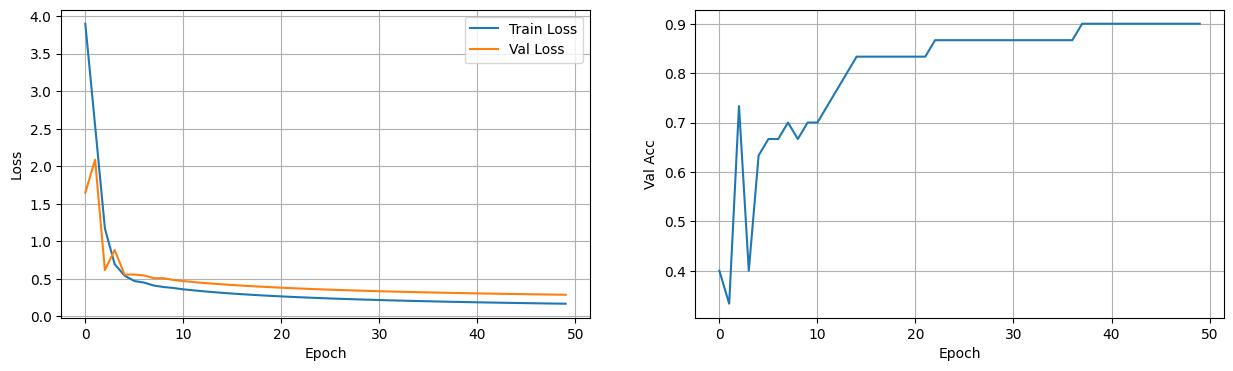

================= Fold 2 =================


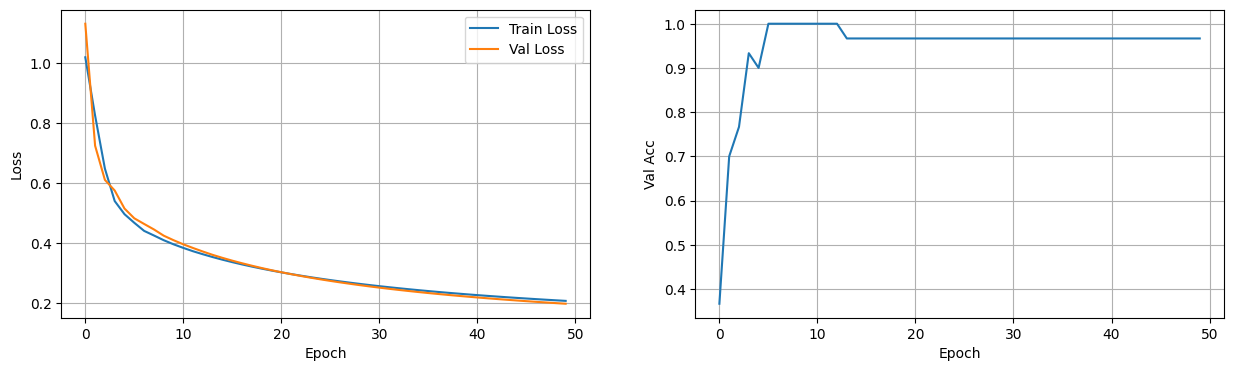

================= Fold 3 =================


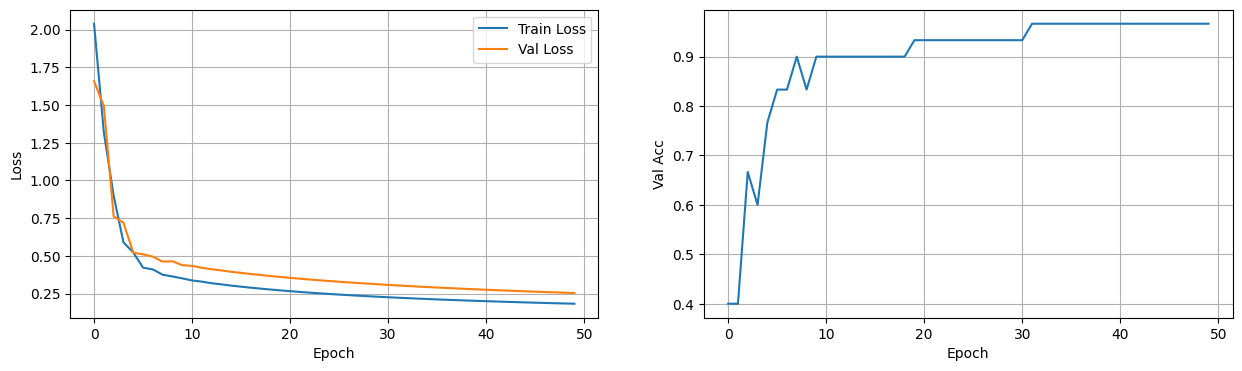

================= Fold 4 =================


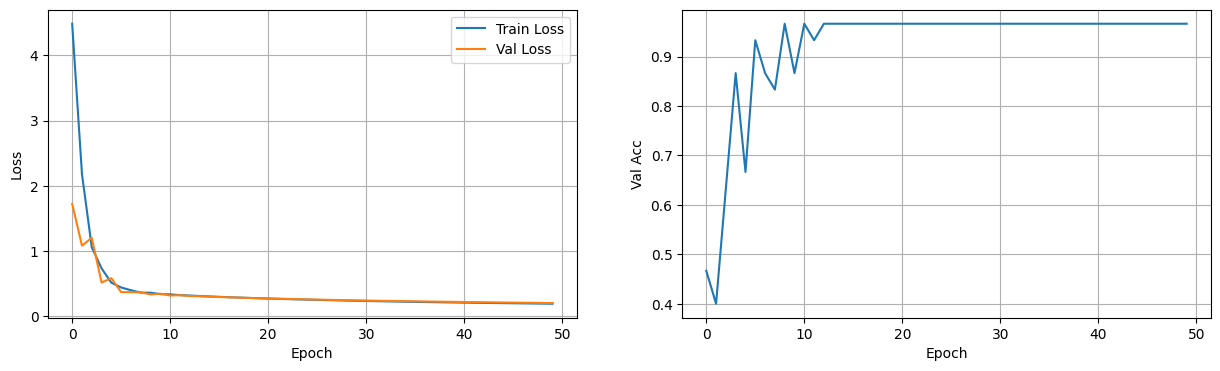

================= Fold 5 =================


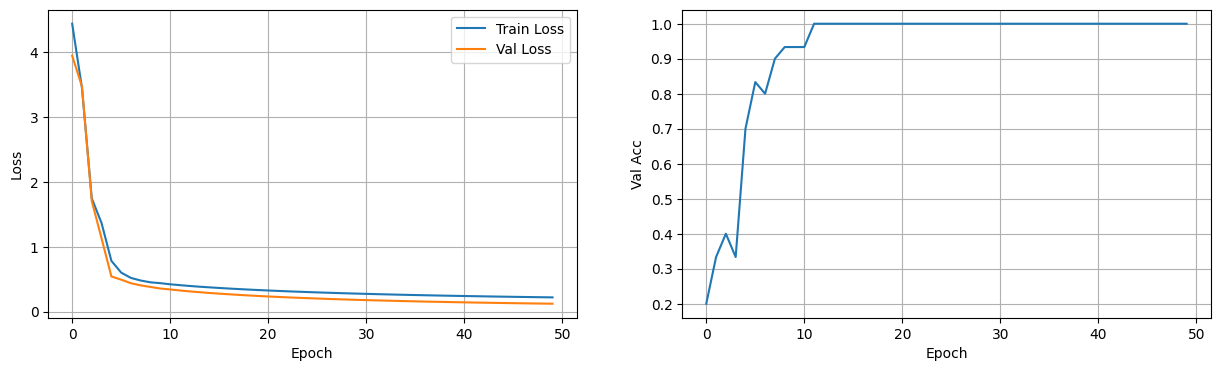

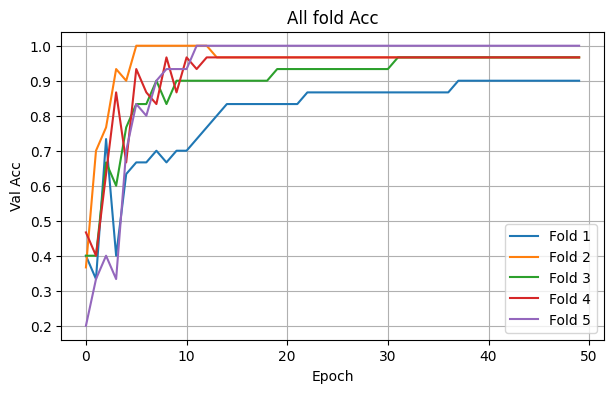

In [113]:
import numpy as np

# 固定隨機種子，確保同參數下每次結果都相同
np.random.seed(1)

with open('Iris.csv') as f:
    data = f.readlines()[1:]

data = [line.strip().split(',')[1:] for line in data]
data = np.array(data)
labels = []

classes = np.unique(data[:, 4])

for d in data:
    for cls in classes:
        if d[4] == cls:
            one_hot = np.zeros(len(classes))
            one_hot[classes.tolist().index(cls)] = 1
            labels.append(one_hot)

inputs = data[:, :4].astype(np.float32)

# inputs = (inputs - np.mean(inputs, axis=0)) / np.std(inputs, axis=0)

labels = np.array(labels)

# 打亂數據
idx = np.random.permutation(len(inputs))

X_data = inputs[idx]

Y_data = labels[idx]

train_size = int(len(X_data) * 0.8)
val_size = len(X_data) - train_size

X_train, Y_train = X_data[:train_size], Y_data[:train_size]
X_val, Y_val = X_data[val_size:], Y_data[val_size:]

print(X_train.shape)

hyper_params = {
    'lr': 0.01,
    'epoch': 50,
    'batch_size': 16,
    'alpha': 0.9
}

FOLD = 5

params_set_list = [
    # (4, 5, ReLU),
    # (5, 5, ReLU),
    (4, 3, Softmax)
]



mlp = MLP(params_set_list)

# params = mlp.train(X_train, Y_train, X_val, Y_val, hyper_params)
mlp.kfold(X_data, Y_data, FOLD, hyper_params)
# params

## ========== breast cancer ==========

In [ ]:
import numpy as np

# 固定隨機種子，確保同參數下每次結果都相同
np.random.seed(1)

with open('breast_cancer.csv') as f:
    # 跳過 first row (標籤名稱)
    data = f.readlines()[1:]

# 濾除第一個 column (Id)
data = [line.strip().split(',')[1:] for line in data]

data = np.array(data)
labels = []

# 第二個 column 為 label
classes = np.unique(data[:, 0])

# 將 label 做 one-hot encoding
for d in data:
    for cls in classes:
        if d[0] == cls:
            one_hot = np.zeros(len(classes))
            one_hot[classes.tolist().index(cls)] = 1
            labels.append(one_hot)

# 將 input features 與 labels 從原始資料中分離
inputs = data[:, 1:].astype(np.float32)
labels = np.array(labels)

# 對 input features 做標準化 (沒有做loss會直接 nan)
inputs = (inputs - np.mean(inputs, axis=0)) / np.std(inputs, axis=0)

# 打亂數據
idx = np.random.permutation(len(inputs))

X_data = inputs[idx]
Y_data = labels[idx]

# 設定 train set 和 val set 的比例 (80% train, 20% val)
train_size = int(len(X_data) * 0.8)
val_size = len(X_data) - train_size

X_train, Y_train = X_data[:train_size], Y_data[:train_size]
X_val, Y_val = X_data[val_size:], Y_data[val_size:]

print(X_train.shape)

hyper_params = {
    'lr': 0.05,
    'epoch': 30,
    'batch_size': 16,
    'alpha': 0.0
}

FOLD = 5

# input features 有 30 個，總共 2 個 classes
params_set_list = [
    # (30, 10, ReLU),
    # (10, 5, ReLU),
    (30, 2, Softmax)
]

mlp = MLP(params_set_list)
mlp.kfold(X_data, Y_data, FOLD, hyper_params)
# params = mlp.train(X_train, Y_train, X_val, Y_val, hyper_params)
# params

## ========== wine ==========

(1279, 11)
classes: ['3' '4' '5' '6' '7' '8']
================= Fold 1 =================


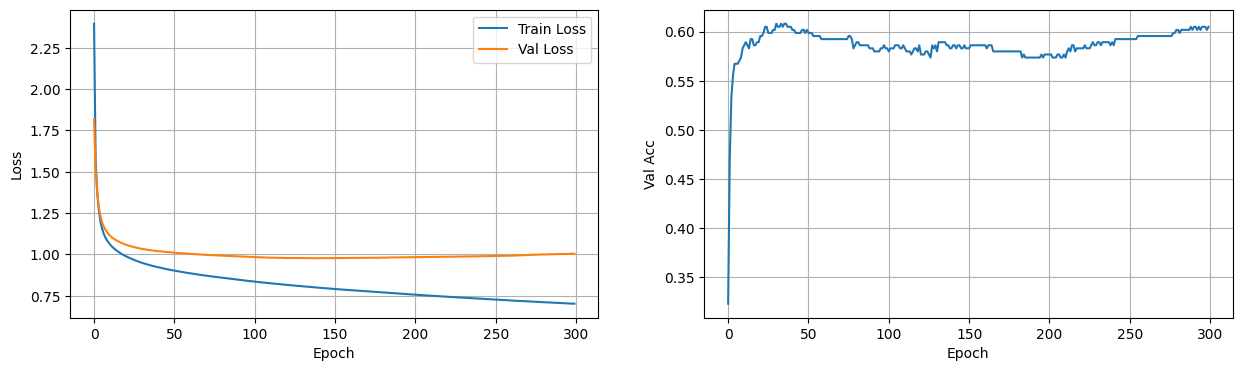

================= Fold 2 =================


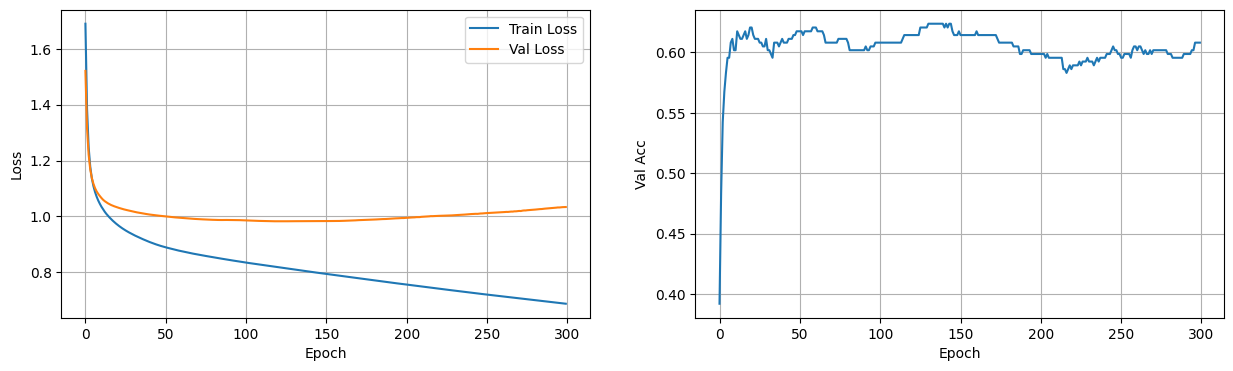

================= Fold 3 =================


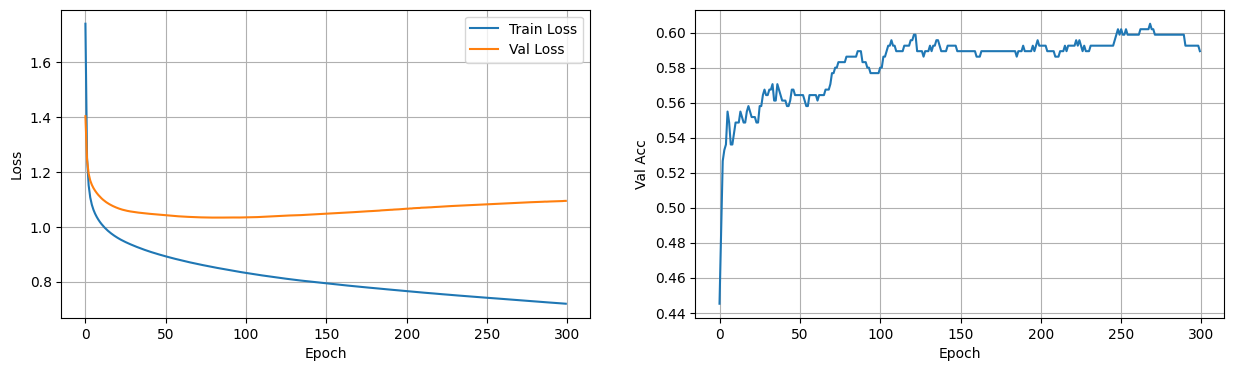

================= Fold 4 =================


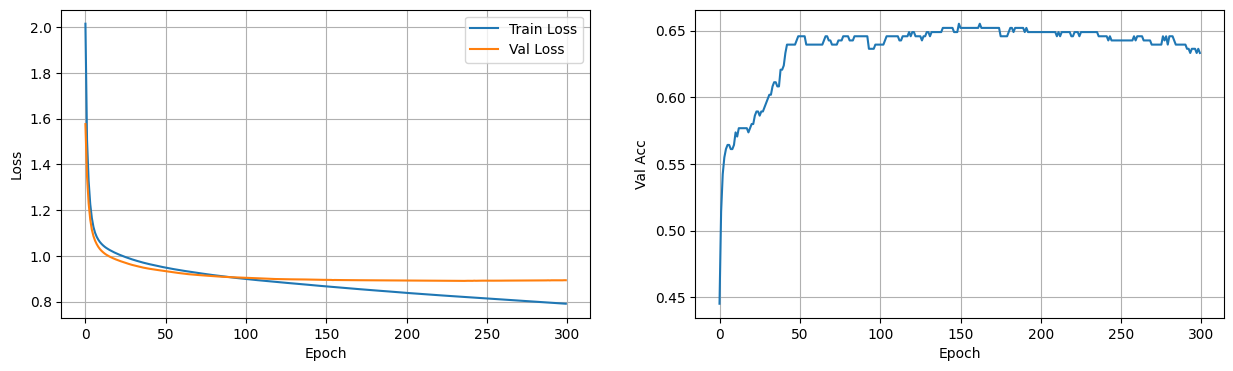

================= Fold 5 =================


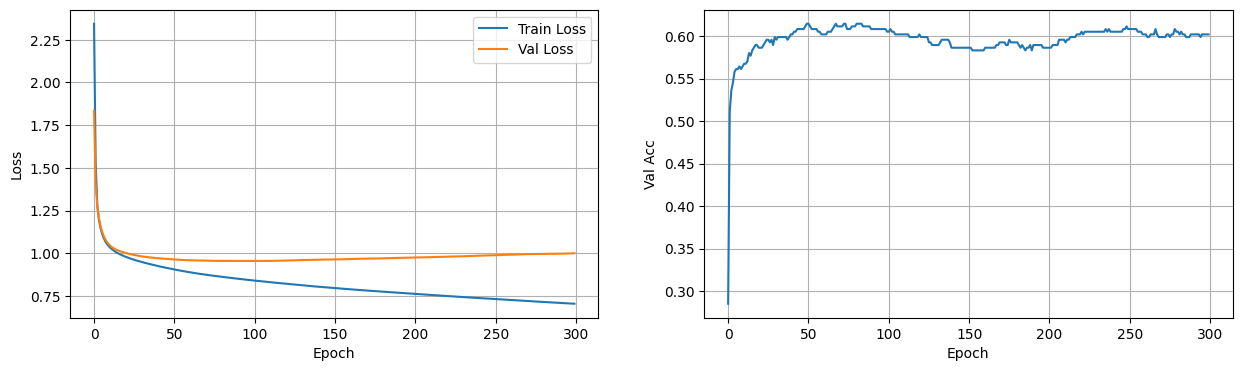

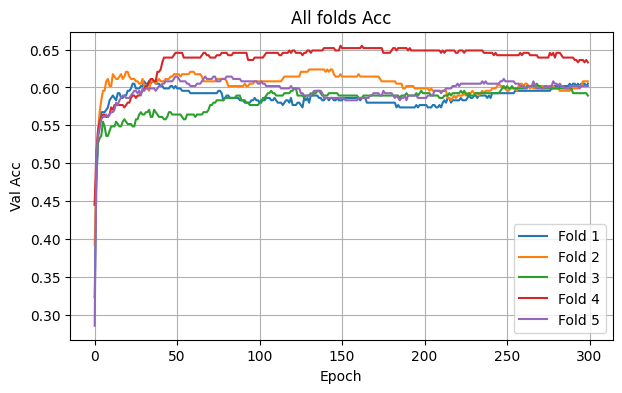

In [ ]:
import numpy as np

# 固定隨機種子，確保同參數下每次結果都相同
np.random.seed(1)

with open('winequality-red.csv') as f:
    # 跳過 first row (標籤名稱)
    data = f.readlines()[1:]

data = [line.strip().split(',') for line in data]

data = np.array(data)
labels = []

# 最後一個 column 為 label
classes = np.unique(data[:, -1])

# 將 label 做 one-hot encoding
for d in data:
    for cls in classes:
        if d[-1] == cls:
            one_hot = np.zeros(len(classes))
            one_hot[classes.tolist().index(cls)] = 1
            labels.append(one_hot)

# 將 input features 與 labels 從原始資料中分離
inputs = data[:, :-1].astype(np.float32)
labels = np.array(labels)

# 對 input features 做標準化 (沒有做loss會直接 nan)
inputs = (inputs - np.mean(inputs, axis=0)) / np.std(inputs, axis=0)

# 打亂數據
idx = np.random.permutation(len(inputs))

X_data = inputs[idx]
Y_data = labels[idx]

# 設定 train set 和 val set 的比例 (80% train, 19% val)
train_size = int(len(X_data) * 0.80)
val_size = len(X_data) - train_size

X_train, Y_train = X_data[:train_size], Y_data[:train_size]
X_val, Y_val = X_data[val_size:], Y_data[val_size:]

print(X_train.shape)
print('classes:', classes)

hyper_params = {
    'lr': 0.001,
    'batch_size': 32,
    'epoch': 300,
    'alpha': 0.9
}

FOLD = 5

# input features 有 11 個，總共 6 個 classes
params_set_list = [
    (11, 32, ReLU),
    (32, 16, ReLU),
    (16, 6, Softmax)
]

mlp = MLP(params_set_list)
# _, _, _ = mlp.train(X_train, Y_train, X_val, Y_val, hyper_params, show_plot=True)
mlp.kfold(X_data, Y_data, FOLD, hyper_params)


### 筆記
在較為複雜的 dataset 避免梯度爆炸 (nan loss) 的方法
- 對 input features 做 normalization
- weight init 使用 Xaviar initialization

反向傳播時將梯度除以 batch size 來取平均可讓收斂較穩定